### Linguistic and structural analysis
 
### Preprocessing

Standard text preprocessing steps were applied to ensure data quality and consistency:

- Tokenization of titles and tags  
- Lowercasing of text  
- Removal of stopwords, special characters, and non-informative tokens  
- Deduplication of near-identical entries  


### NLP Techniques


1. **Part-of-Speech (POS) Tagging**  
  Identifies grammatical roles and recurring syntactic patterns.
  
1. **Dependency Parsing**  
  Examines how **gendered** and **racialized** terms are positioned within phrases, revealing structural relationships.

1. **Bigram and Trigram Modeling**  
  Captures frequently occurring word sequences and stereotypical expressions.



In [1]:
import pandas as pd
from collections import Counter
import src.models.embeddings as embeddings
import src.utils.helpers as helpers
import src.data.clean as clean

import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

/home/olga/Documents/eur-porntypes/stereotype-map/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
columns_to_read = [
    "url",
    "title",
    "categories",
    "date",
    "views",
    "upvotes"
  ]

df = pd.read_csv("data/raw/data2008-2024.csv", usecols=columns_to_read)
df.tail(25)

,url,title,categories,date,views,upvotes
256101,https://www.pornhub.com/view_video.php?viewkey...,BANGBROS - Brother Goes Deep in Step Sister Aa...,"['Anal', 'Babe', 'Big Ass', 'Big Tits', 'HD Po...",2017-10-18,NaN,NaN
256102,https://www.pornhub.com/view_video.php?viewkey...,Ele queria jogar video game e eu queria dar o ...,"['Amateur', 'Anal', 'Big Ass', 'Brazilian', 'H...",2024-07-14,NaN,NaN
256103,https://www.pornhub.com/view_video.php?viewkey...,Throat dragon Latina gets pounded by BWC,"['18-25', 'Big Ass', 'Big Dick', 'Blowjob', 'C...",2023-01-27,NaN,NaN
256104,https://www.pornhub.com/view_video.php?viewkey...,busty horny mom,"['Big Tits', 'MILF', 'Mature']",2012-07-06,NaN,NaN
256105,https://www.pornhub.com/view_video.php?viewkey...,Fingering my wet pussy in leather mini skirt a...,"['18-25', 'Big Tits', 'Brunette', 'Exclusive',...",2020-10-17,NaN,NaN
256106,https://www.pornhub.com/view_video.php?viewkey...,DOEGIRLS - Sexy Big Tits Blonde Kaisa Nord Rid...,"['Babe', 'Big Ass', 'Big Tits', 'Female Orgasm...",2022-08-20,NaN,NaN
256107,https://www.pornhub.com/view_video.php?viewkey...,Boyfriends Bareback Cum Compilation - Vol 1,"['Amateur', 'Bareback', 'Big Dick', 'Compilati...",2021-06-05,NaN,NaN
256108,https://www.pornhub.com/view_video.php?viewkey...,【盗撮】貧乳女子にバレないように隠し撮りする Japanese,"['Amateur', 'Babe', 'Blowjob', 'Exclusive', 'H...",2022-01-15,NaN,NaN
256109,https://www.pornhub.com/view_video.php?viewkey...,Giochi di specchi - Da sola a casa mi masturbo...,"['Amateur', 'Big Ass', 'Female Orgasm', 'HD Po...",2021-06-12,5400.0,46.0
256110,https://www.pornhub.com/view_video.php?viewkey...,Busty MILF Brought Home Mistress to Play,"['Babe', 'Big Ass', 'Big Tits', 'FFM in Threes...",2020-03-22,NaN,NaN


In [3]:
import os
plot_output_path = "plots"
data_output_path = "data/processed"

os.makedirs(plot_output_path, exist_ok=True)  # ensure the folder exists
os.makedirs(data_output_path, exist_ok=True)  

%load_ext autoreload
%autoreload 2


In [4]:
pd.to_datetime(df.date).max()


Timestamp('2024-08-08 00:00:00')

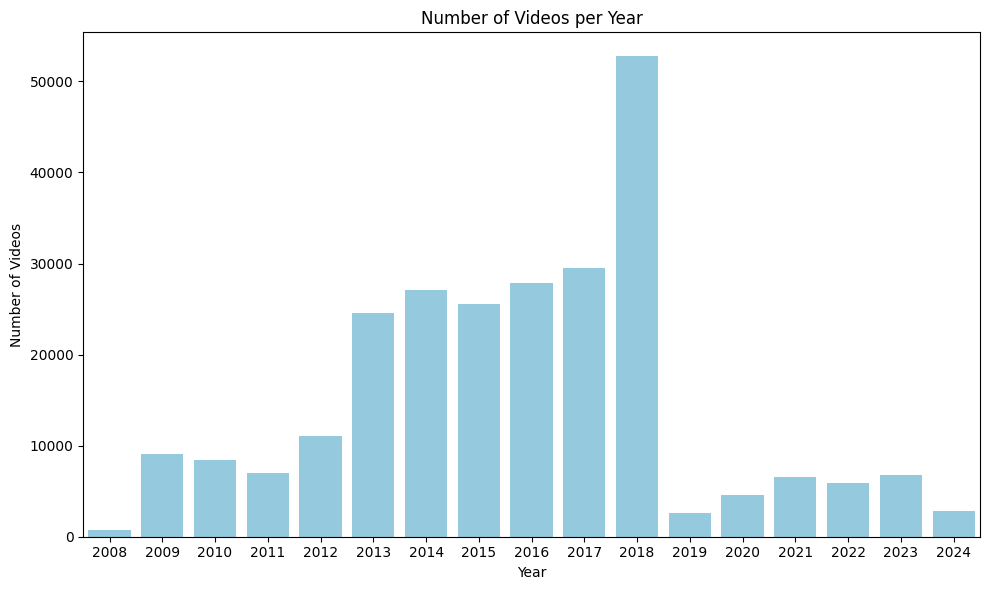

In [5]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

videos_per_year = df["year"].value_counts().sort_index()

# Plot number of videos per year
plt.figure(figsize=(10, 6))
sns.barplot(x=videos_per_year.index.astype(int), y=videos_per_year.values, color="skyblue")
plt.xlabel("Year")
plt.ylabel("Number of Videos")
plt.title("Number of Videos per Year")
plt.tight_layout()
plt.savefig(os.path.join(plot_output_path, "videos_per_year.png"), bbox_inches="tight")
plt.show()

In [6]:
# Statistics on the counts (number of videos per year)
mean_count = videos_per_year.mean()
std_count = videos_per_year.std()
min_count = videos_per_year.min()
max_count = videos_per_year.max()

print(f"Minimum videos in a year: {min_count}")
print(f"Maximum videos in a year: {max_count}")
print(f"Mean videos per year: {mean_count:.2f}")
print(f"Standard deviation of videos per year: {std_count:.2f}")

Minimum videos in a year: 763
Maximum videos in a year: 52746
Mean videos per year: 14881.35
Standard deviation of videos per year: 14023.94


### 1. Tag analysis


##### Frequency and correlation

In [7]:
# TODO: do not confuse tags with categories
# Create 'tags' column from categories
df["tags"] = df["categories"].apply(clean.extract_tags)
df = df.drop(columns=["categories"])
# Remove a specific tag from the "tags" column
df["tags"] = df["tags"].apply(clean.remove_tag, tag_to_remove="HD Porn")
# confirm it is a list
# df.tags.apply(lambda tag_list: isinstance(tag_list, list))

In [8]:
# flatten out tags
df_flat_tag = clean.flatten_tags(df.tags)
# number of unique hashtags
df_flat_tag["tag"].unique().size

140

In [9]:
# count the number of each hashtag
popular_tags_set = clean.get_popular_tags(df_flat_tag)

# make a new column with only the popular tags
df["popular_tags"] = df.tags.apply(
    lambda tag_list: clean.filter_popular_tags(tag_list, popular_tags_set)
)
# replace url with identifier
df["url"] = df.url.apply(lambda x: helpers.extract_and_create_unique_id(x, length=11))

# drop rows without popular tag
df_popular_tags = df.loc[df.popular_tags.apply(lambda tag_list: tag_list != [])]
df_tags_vector = df_popular_tags.loc[:, ["popular_tags"]]

for tag in popular_tags_set:
    # make columns to encode presence of hashtags
    df_tags_vector["{}".format(tag)] = df_tags_vector.popular_tags.apply(
        lambda tag_list: int(tag in tag_list)
    )
# create a matrix of tags
tag_matrix = df_tags_vector.drop("popular_tags", axis=1)

In [10]:
# tag_matrix.head(5)

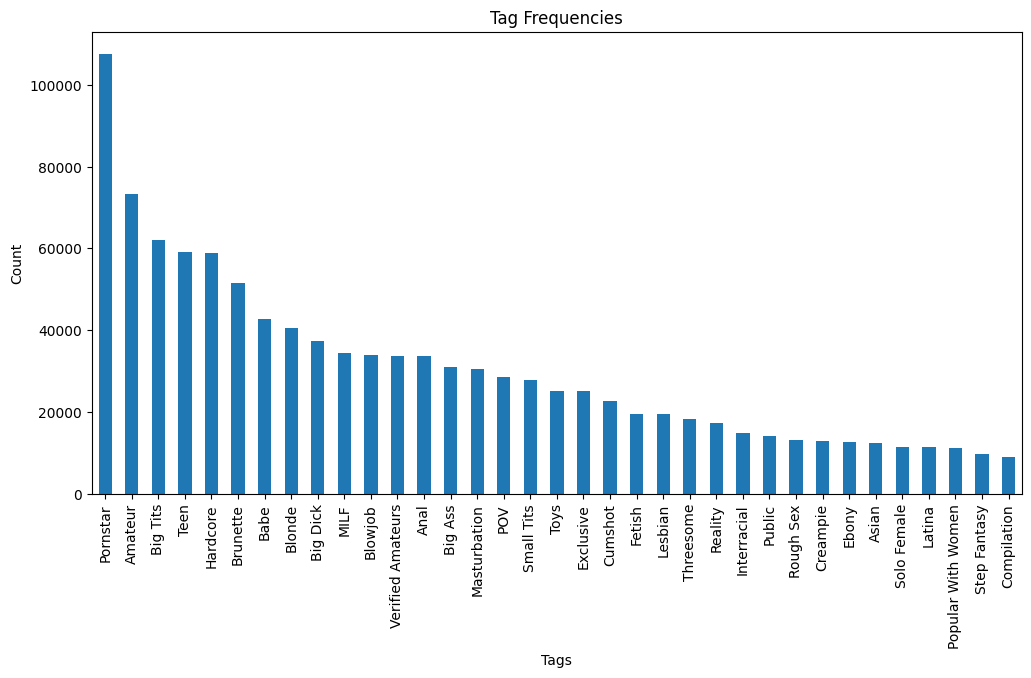

In [11]:
tag_counts = tag_matrix.sum().sort_values(ascending=False)
tag_counts.plot(kind="bar", figsize=(12, 6))
plt.title("Tag Frequencies")
plt.xlabel("Tags")
plt.ylabel("Count")
plt.xticks(rotation=90)
output_plot_path = "plots/tag_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

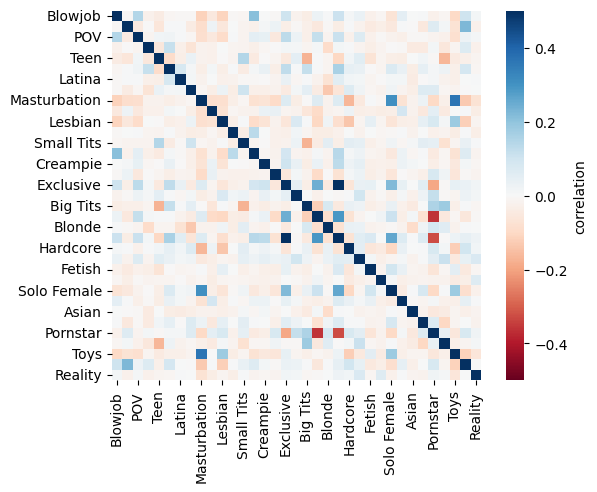

In [12]:
# correlation matrix
correlations = tag_matrix.corr()

sns.heatmap(
    correlations,
    cmap="RdBu",
    vmin=-0.5,
    vmax=0.5,
    square=True,
    cbar_kws={"label": "correlation"},
)
plt.savefig("plots/tag_correlation.png")

In [13]:
# Extract year from date
df["year"] = pd.to_datetime(df["date"]).dt.year

# Explode the popular_tags list so each tag gets its own row
df_exploded = df.explode("popular_tags")

# Group by year and tag, count occurrences
tag_counts = df_exploded.groupby(["year", "popular_tags"]).size().unstack(fill_value=0)

# Normalize counts to get frequencies
tag_frequencies = tag_counts.div(tag_counts.sum(axis=1), axis=0)


In [14]:
tag_frequencies.head(5)

popular_tags,Amateur,Anal,Asian,Babe,Big Ass,Big Dick,Big Tits,Blonde,Blowjob,Brunette,...,Public,Reality,Rough Sex,Small Tits,Solo Female,Step Fantasy,Teen,Threesome,Toys,Verified Amateurs
year,,,,,,,,,,,,,,,,,,,,,
2008.0,0.208204,0.037912,0.022996,0.014295,0.014916,0.005594,0.054692,0.070230,0.025482,0.077067,...,0.017402,0.016159,0.023617,0.001243,0.000622,0.000000,0.022996,0.029832,0.029832,0.000000
2009.0,0.073485,0.055942,0.016053,0.022347,0.012812,0.009721,0.079631,0.051548,0.016686,0.055272,...,0.008678,0.032329,0.033521,0.002793,0.000037,0.000149,0.049536,0.018623,0.028232,0.000000
2010.0,0.074080,0.071142,0.019730,0.004841,0.017393,0.012219,0.088402,0.043233,0.002871,0.073045,...,0.012286,0.035555,0.030981,0.048741,0.000000,0.000100,0.050711,0.014389,0.036656,0.000234
2011.0,0.073515,0.052689,0.016391,0.015525,0.025641,0.022449,0.057882,0.038624,0.014173,0.037866,...,0.019907,0.035216,0.004923,0.010224,0.000000,0.002542,0.074110,0.024126,0.032511,0.000216
2012.0,0.097178,0.049666,0.018371,0.025847,0.019322,0.019575,0.062589,0.036236,0.022679,0.032847,...,0.019068,0.016439,0.009566,0.013018,0.000063,0.003643,0.080865,0.029711,0.025688,0.000190


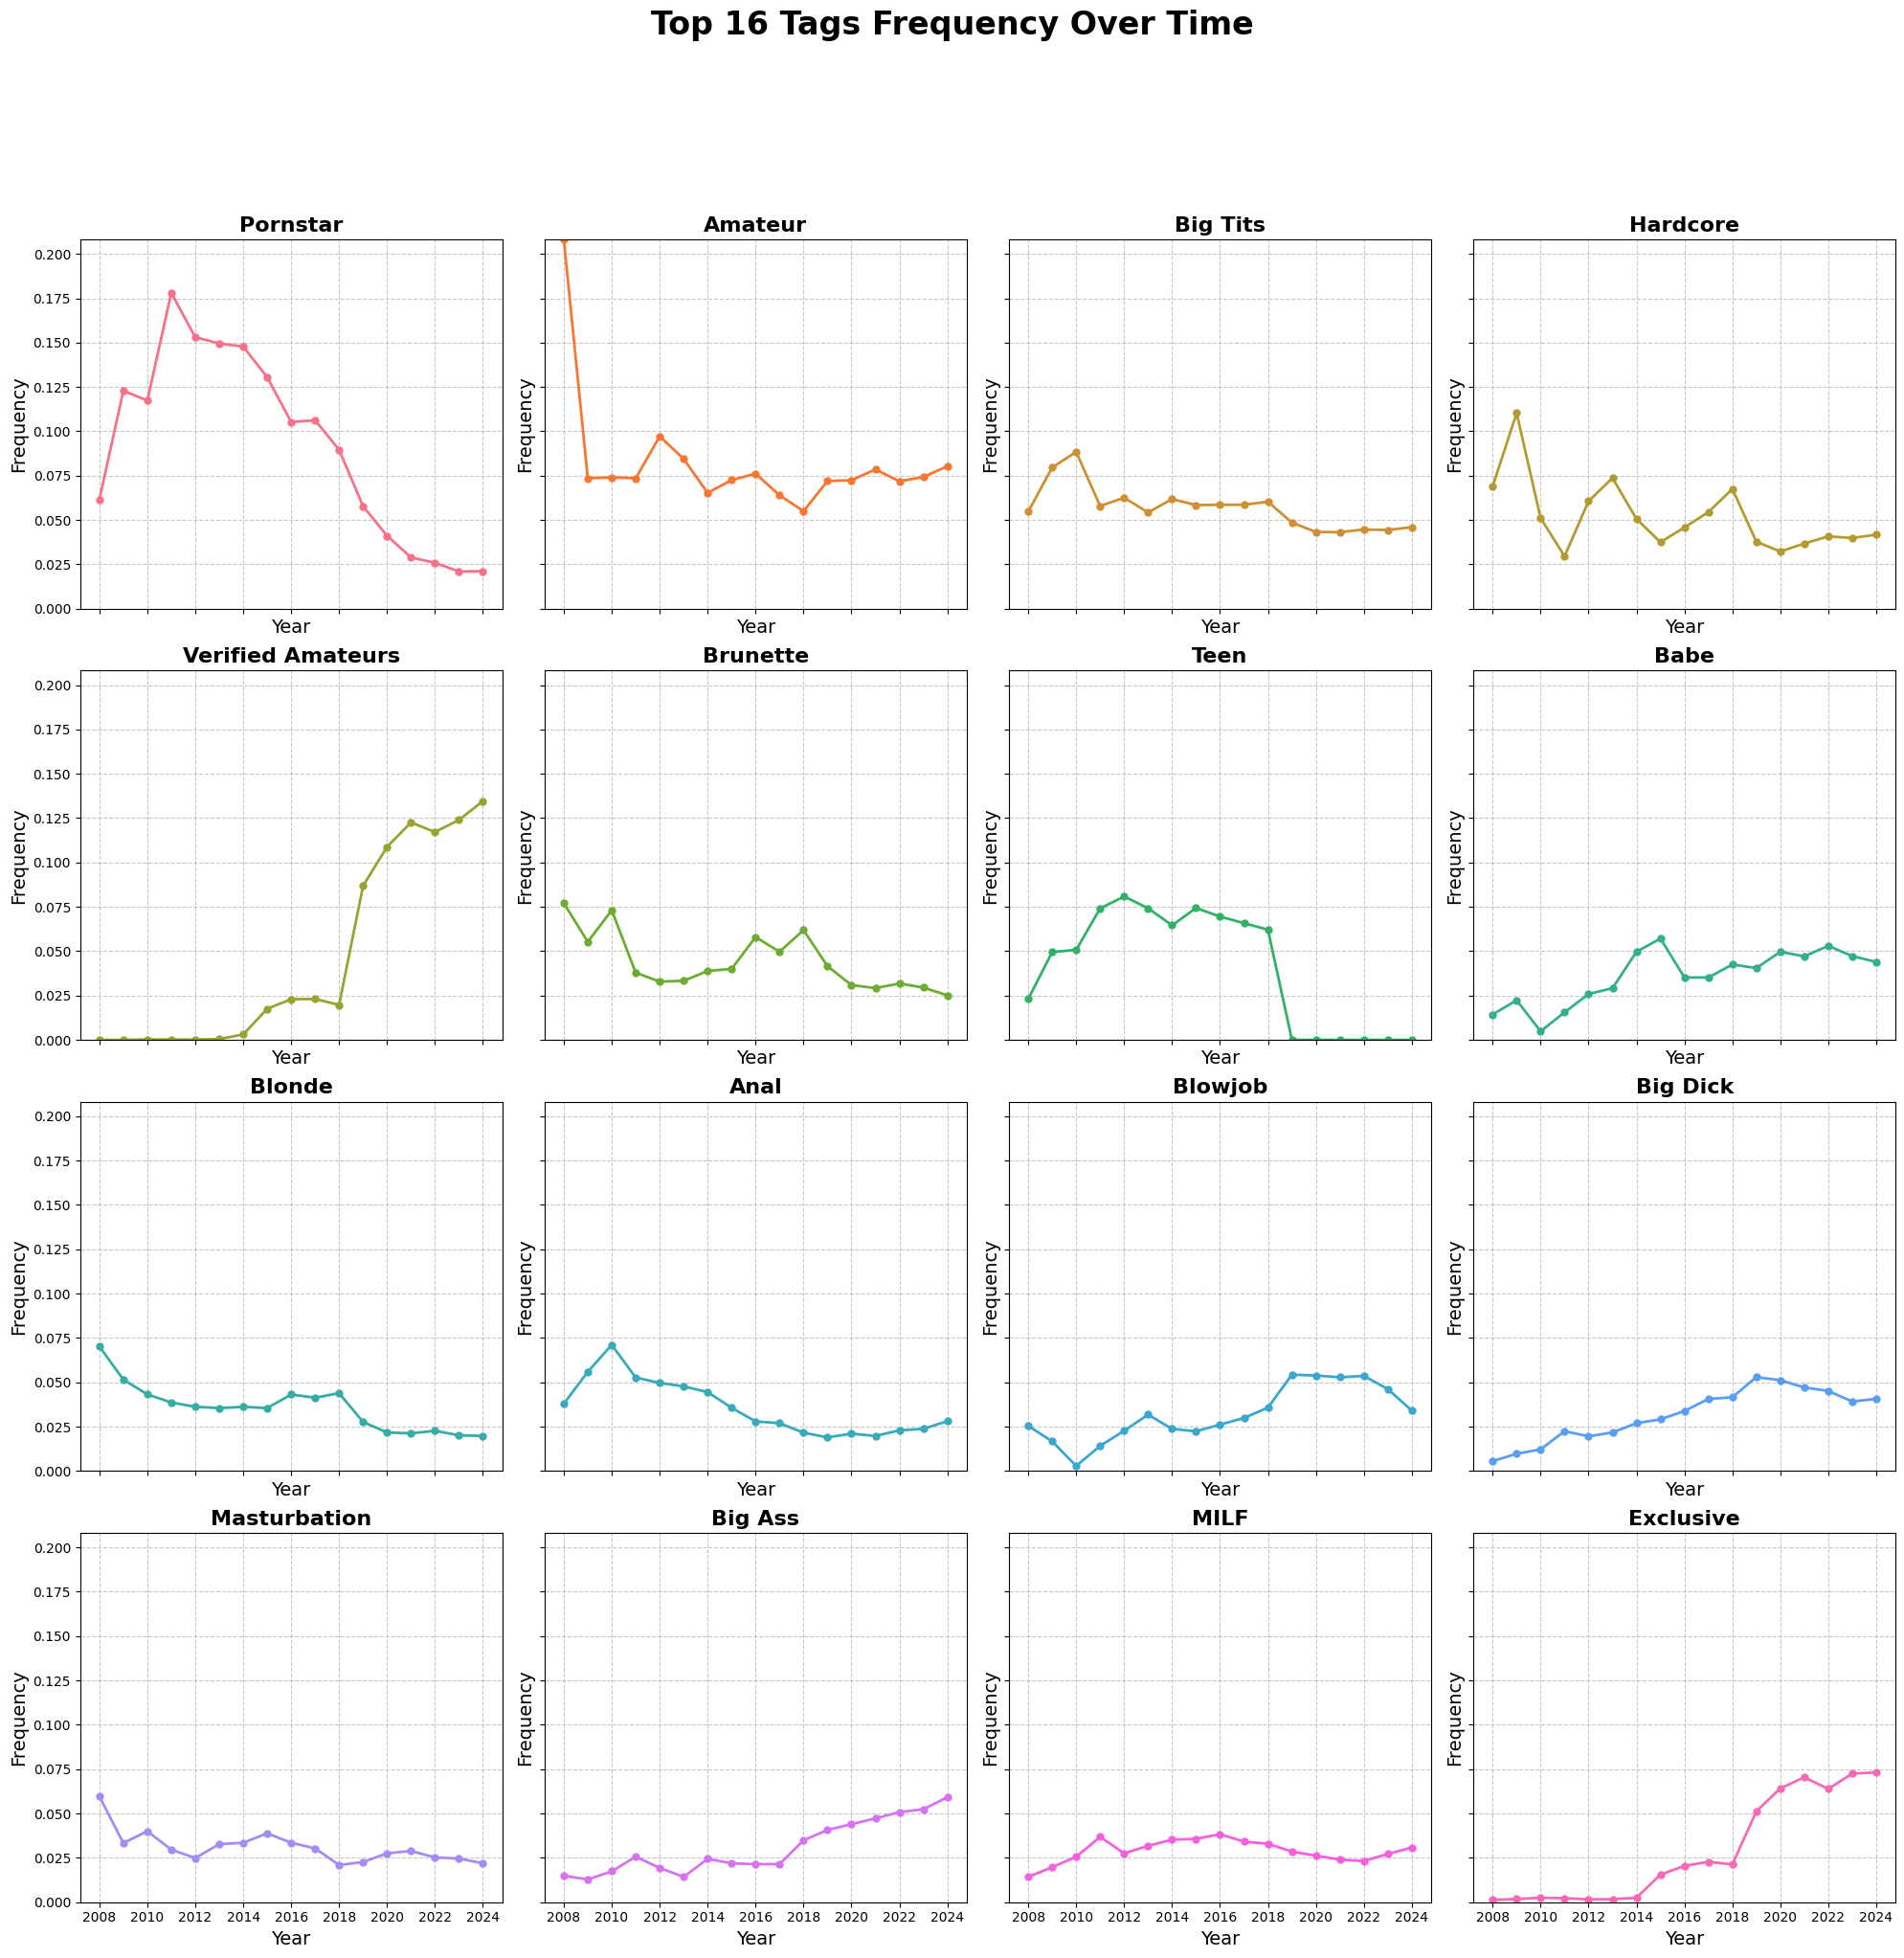

In [15]:
top_tags = tag_frequencies.sum().nlargest(16).index  # Choose top 16 tags
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Set a color palette
colors = sns.color_palette("husl", len(top_tags))

for i, tag in enumerate(top_tags):
    axes[i].plot(
        tag_frequencies.index,
        tag_frequencies[tag],
        color=colors[i],
        linewidth=2,
        marker="o",
        markersize=5,
    )
    axes[i].set_title(tag, fontsize=16, fontweight="bold")
    axes[i].set_ylim(0, tag_frequencies[top_tags].max().max())
    axes[i].set_xlabel("Year", fontsize=14)
    axes[i].set_ylabel("Frequency", fontsize=14)
    axes[i].grid(
        True, linestyle="--", alpha=0.7
    )  # Add grid lines for better readability

# Adjust layout and aesthetics
plt.suptitle("Top 16 Tags Frequency Over Time", fontsize=24, fontweight="bold", y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
output_plot_path = "plots/top_16_tags_frequency_distribution_time.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

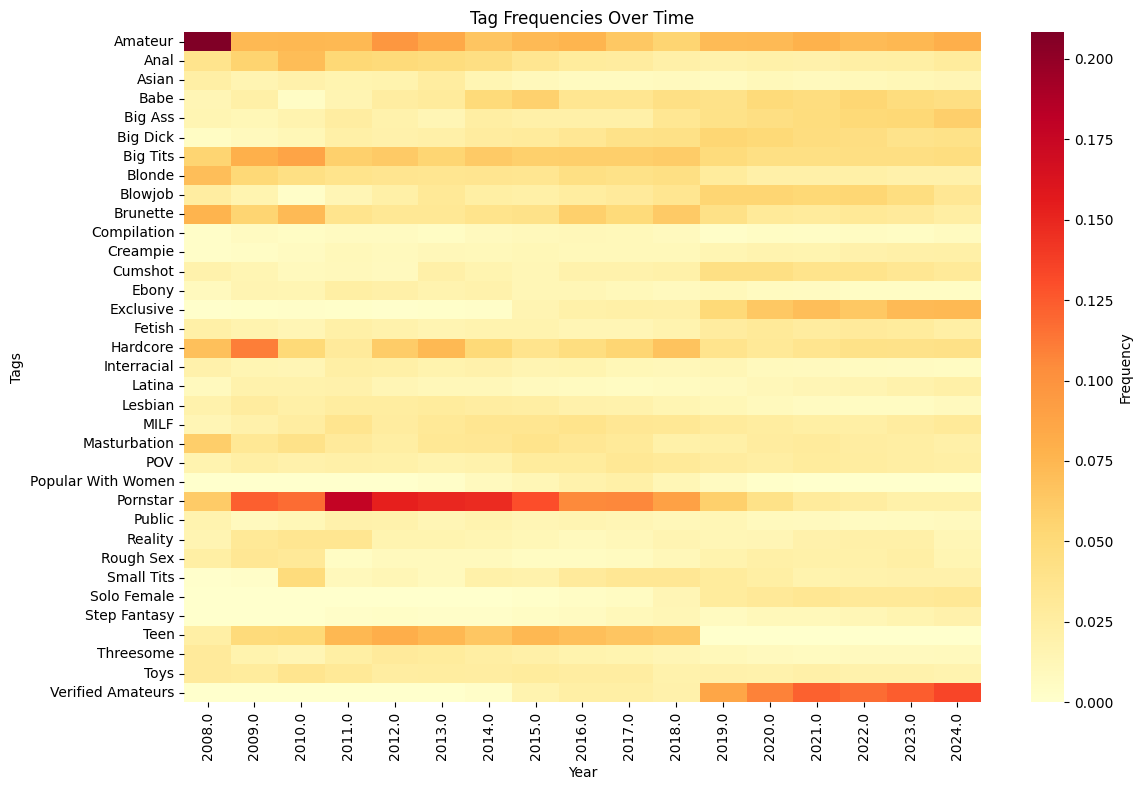

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(tag_frequencies.T, cmap="YlOrRd", cbar_kws={"label": "Frequency"})
plt.title("Tag Frequencies Over Time")
plt.xlabel("Year")
plt.ylabel("Tags")
plt.tight_layout()
output_plot_path = "plots/tag_frequency_time.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

#### POS tagging
POS tagging is a grammatical classification that includes verbs, adjectives, adverbs, nouns, etc.



- What adjectives co-occur with gendered or racial terms?
- Group adjectives that co-occur with gendered or racialised nouns to reveal stereotype patterns?
- Are women-associated tags more likely to include appearance-based adjectives?
- Are men more often subjects of action verbs (agency bias)?


Linguistic bias analysis of adult content metadata

#### Dependency Parsing

#### N-grams

### 2. Title analyses


#### Adjective noun pairs in titles



In [17]:
# Calculate title lengths
df["title_length"] = df["title"].astype(str).apply(len)

# Get statistics
mean_length = df["title_length"].mean()
median_length = df["title_length"].median()
std_length = df["title_length"].std()
min_length = df["title_length"].min()
max_length = df["title_length"].max()

print(f"Mean title length: {mean_length:.2f}")
print(f"Median title length: {median_length}")
print(f"Standard deviation: {std_length:.2f}")
print(f"Min title length: {min_length}")
print(f"Max title length: {max_length}")

Mean title length: 40.78
Median title length: 39.0
Standard deviation: 17.54
Min title length: 1
Max title length: 102


In [18]:
from src.models import embeddings

embeddings.download_nltk_data()

# Ensure all titles are strings and fill NaN with empty string
df["title"] = df["title"].fillna("").astype(str)

# Apply the function to the title column
df["title_words"] = df["title"].apply(embeddings.clean_tokenize_and_stem)

# Flatten the list of words and count frequencies
all_words = [word for words in df["title_words"] for word in words]
word_counts = Counter(all_words)

# Get the most common words
most_common_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
word_freq_df = pd.DataFrame(most_common_words, columns=["word", "count"])



[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
df.title_words

0                           [cute, teen, gloryhol, handjob]
1         [reali, nice, step, mom, angi, give, titjob, g...
2                               [step, mom, gift, son, pov]
3                       [baltimor, street, hooker, creampi]
4                           [cute, blond, brunett, pleasur]
                                ...                        
256121                                      [video, disabl]
256122                                      [famou, youtub]
256123                              [finger, squirt, pussi]
256124    [esposa, le, entrega, el, culo, su, vecino, lo...
256125                 [mädchen, masturbiert, im, solarium]
Name: title_words, Length: 256126, dtype: object

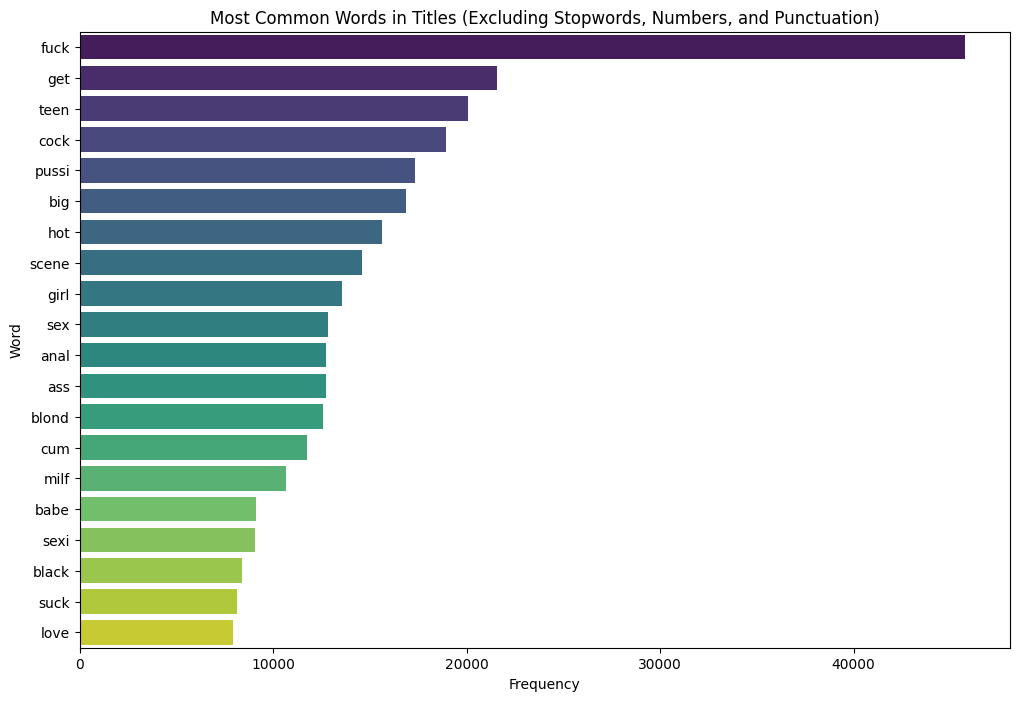

In [20]:
# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="word", data=word_freq_df, hue="word", palette="viridis")
plt.title("Most Common Words in Titles (Excluding Stopwords, Numbers, and Punctuation)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.savefig(os.path.join(plot_output_path,"words_titles_frequency_distribution.eps"), bbox_inches="tight")
plt.show()

#### POS tagging

In [21]:
from src.models.extract_adj_noun_pairs import run_pipeline

# Run pipeline and keep everything
df, pair_df = run_pipeline(
    df,
    cache_filename="pos_title_with_deps.pkl",
    output_csv="adjective_noun_pairs.csv",
    return_pair_df=True,
    data_output_path="data/processed"
)



Loading cached POS data...
Saved 30493 adjective–noun pairs to data/processed/adjective_noun_pairs.csv


In [22]:
df.pos_title_with_deps

0         [(cute, ADJ, amod), (teen, NOUN, compound), (g...
1         [(reali, PROPN, amod), (nice, ADJ, amod), (ste...
2         [(step, NOUN, ROOT), (mom, NOUN, compound), (g...
3         [(baltimor, PROPN, compound), (street, PROPN, ...
4         [(cute, ADJ, amod), (blond, PROPN, compound), ...
                                ...                        
256121      [(video, NOUN, compound), (disabl, NOUN, ROOT)]
256122           [(famou, ADJ, amod), (youtub, NOUN, ROOT)]
256123    [(finger, NOUN, compound), (squirt, PROPN, com...
256124    [(esposa, PROPN, compound), (le, PROPN, compou...
256125    [(mädchen, ADV, advmod), (masturbiert, VERB, R...
Name: pos_title_with_deps, Length: 256126, dtype: object

##### What are the most common adjective–noun pairings in titles?

/tmp/ipykernel_4807/3449694622.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pairs, y="pair_str", x="Count", palette="viridis")


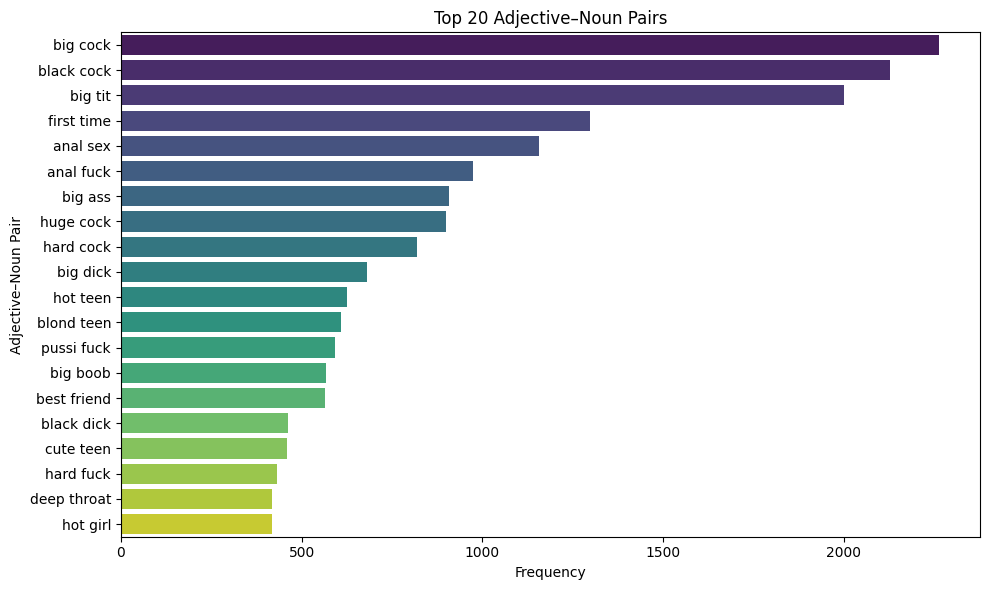

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top N pairs
top_n = 20
top_pairs = pair_df.head(top_n).copy()
top_pairs["pair_str"] = top_pairs["Pair"].apply(lambda x: f"{x[0]} {x[1]}")

plt.figure(figsize=(10, 6))
sns.barplot(data=top_pairs, y="pair_str", x="Count", palette="viridis")
plt.title(f"Top {top_n} Adjective–Noun Pairs")
plt.xlabel("Frequency")
plt.ylabel("Adjective–Noun Pair")
plt.tight_layout()
plt.savefig(os.path.join(plot_output_path,"adjective-noun-pair.eps"), bbox_inches="tight")
plt.show()


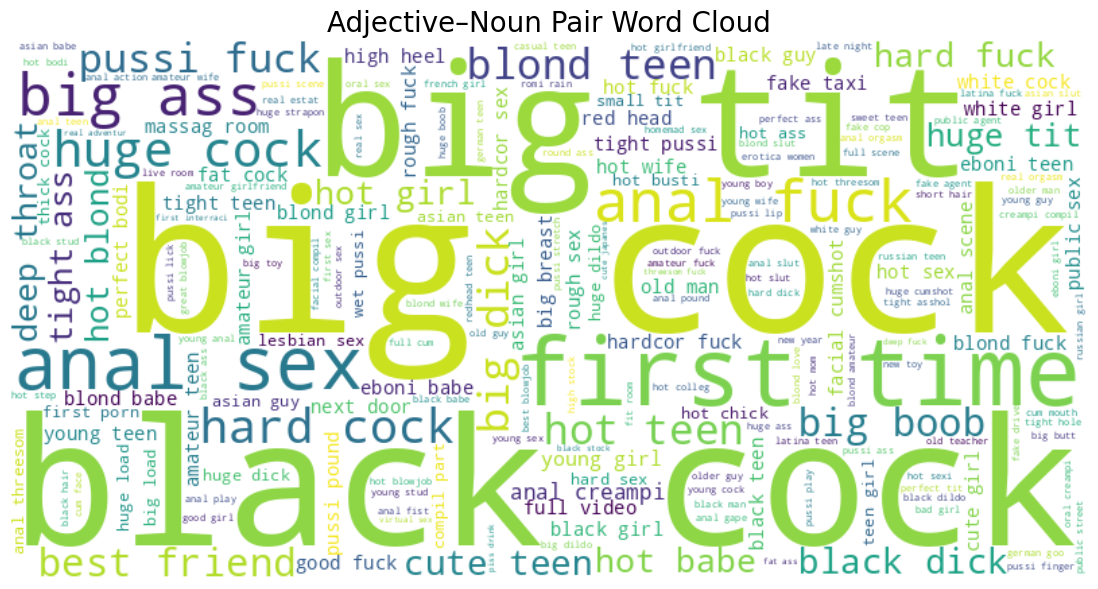

In [24]:
from wordcloud import WordCloud

# Prepare data for word cloud
pair_freq_dict = {f"{adj} {noun}": count for (adj, noun), count in pair_df.head(1000).values}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pair_freq_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Adjective–Noun Pair Word Cloud", fontsize=20)
plt.savefig(os.path.join(plot_output_path,"adj-noun-pair-word-cloud.eps"), bbox_inches="tight")
plt.show()


In [25]:
# Different ways to say pussy..using levenshtein distance

import difflib
from collections import Counter

# Flatten all words from title_words
all_words = [word for words in df["title_words"] for word in words]

# Get unique words to speed up matching
unique_words = set(all_words)

# Find words with high similarity to "pussy"
matches = [w for w in unique_words if difflib.SequenceMatcher(None, w, "pussy").ratio() > 0.7]

# Count their frequencies in the corpus
fuzzy_counts = Counter([w for w in all_words if w in matches])

# Show the most common fuzzy matches
print(fuzzy_counts.most_common(20))

[('pussi', 17338), ('pussylick', 76), ('puss', 62), ('pussyfuck', 26), ('pussyrub', 11), ('pussycat', 11), ('pusssi', 11), ('pussyjob', 9), ('pussyeat', 9), ('pussyman', 7), ('pussykat', 6), ('pussylov', 5), ('pussy_ful', 3), ('pussypov', 2), ('pussysh', 2), ('pussynail', 2), ('pussylici', 2), ('pussyy', 2), ('pussyplay', 2), ('pussylip', 2)]


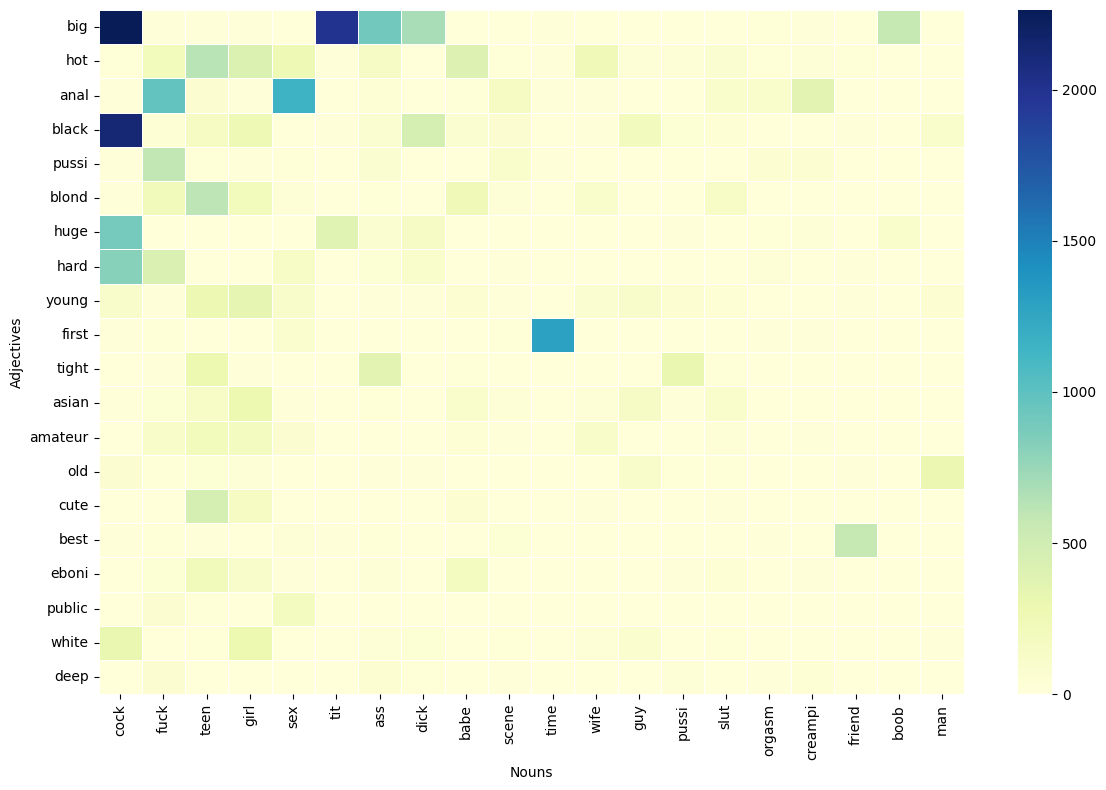

In [26]:
# Create a DataFrame for heatmap: rows = adjectives, cols = nouns

heat_df = pair_df.copy()
heat_df["Adjective"] = heat_df["Pair"].apply(lambda x: x[0])
heat_df["Noun"] = heat_df["Pair"].apply(lambda x: x[1])

pivot = heat_df.pivot_table(index="Adjective", columns="Noun", values="Count", fill_value=0)
pivot_top = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).head(20).index,  # top 20 adjectives
                      pivot.sum().sort_values(ascending=False).head(20).index]        # top 20 nouns

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_top, cmap="YlGnBu", linewidths=0.5)
plt.xlabel("Nouns")
plt.ylabel("Adjectives")
plt.tight_layout()
plt.savefig(os.path.join(plot_output_path,"heatmap-adj-noun-pair.eps"), bbox_inches="tight")
plt.savefig(os.path.join(plot_output_path,"heatmap-adj-noun-pair.png"), bbox_inches="tight")
plt.show()


In [69]:
# Save the DataFrame with adjective-noun pairs to a CSV file
adjective_noun_df = pd.DataFrame(pair_df["Pair"].tolist(), columns=["Adjective", "Noun"])
adjective_noun_df["Count"] = pair_df["Count"].values
adjective_noun_df.to_csv("data/processed/adjective_noun_pairs_split.csv", index=False)

# Count total occurrences of each noun in adjective–noun pairs
noun_counts = adjective_noun_df.groupby("Noun")["Count"].sum().sort_values(ascending=False).reset_index()
noun_counts.columns = ["Noun", "Total_Count"]
noun_counts.to_csv("data/processed/noun_counts.csv", index=False)

# Count total occurrences of each adjective in adjective–noun pairs

adjective_counts = adjective_noun_df.groupby("Adjective")["Count"].sum().sort_values(ascending=False).reset_index()
adjective_counts.columns = ["Adjective", "Total_Count"]
adjective_counts.to_csv("data/processed/adjective_counts.csv", index=False)

noun_counts.head(20)

,Noun,Total_Count
0,cock,8030
1,fuck,6032
2,teen,4938
3,girl,4800
4,sex,4351
5,tit,2969
6,ass,2896
7,dick,1745
8,babe,1741
9,scene,1736


In [ ]:
# Use fasttext to assign gender to nouns
import fasttext.util

# Download and load the English FastText model
fasttext.util.download_model('en', if_exists='ignore')  # Downloads cc.en.300.bin
ft = fasttext.load_model('cc.en.300.bin')  # Load model

import numpy as np

# Define gender anchor sets
FEMALE_ANCHORS = ["woman", "girl", "mother", "female", "her"]
MALE_ANCHORS = ["man", "boy", "father", "male", "his"]

def predict_gender_fasttext(word, threshold=0.05):
    vec = ft.get_word_vector(word.lower())
    # Average similarity with anchors
    female_sim = np.mean([ft.get_word_vector(a).dot(vec) /
                          (np.linalg.norm(ft.get_word_vector(a)) * np.linalg.norm(vec))
                          for a in FEMALE_ANCHORS])
    male_sim = np.mean([ft.get_word_vector(a).dot(vec) /
                        (np.linalg.norm(ft.get_word_vector(a)) * np.linalg.norm(vec))
                        for a in MALE_ANCHORS])
    diff = female_sim - male_sim
    if diff > threshold:
        return "Female", female_sim, male_sim
    elif diff < -threshold:
        return "Male", female_sim, male_sim
    else:
        return "Neutral", female_sim, male_sim

# Your noun list with counts
data = [
    ("cock", 8030), ("fuck", 6032), ("teen", 4938),
    ("girl", 4800), ("sex", 4351), ("tit", 2969),
    ("ass", 2896), ("dick", 1745), ("babe", 1741),
    ("scene", 1736), ("time", 1624), ("wife", 1112),
    ("guy", 1109), ("pussi", 1086), ("slut", 1029),
    ("orgasm", 862), ("creampi", 847), ("friend", 813),
    ("boob", 802), ("man", 766)
]

df = pd.DataFrame(data, columns=["Noun", "Total_Count"])

# Predict gender
results = df["Noun"].apply(lambda w: predict_gender_fasttext(w))
df[['Gender', 'Female_Sim', 'Male_Sim']] = pd.DataFrame(results.tolist(), index=df.index)

print(df)


In [32]:
# Focus on nouns of interest
# Samira
adjective_noun_df

,Adjective,Noun,Count
0,big,cock,2263
1,black,cock,2128
2,big,tit,1999
3,first,time,1298
4,anal,sex,1156
...,...,...,...
30488,dominikapriv,show,1
30489,other,teen,1
30490,stranger,adult,1
30491,creampi,sundress,1


2025-06-17 14:10:35,705 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


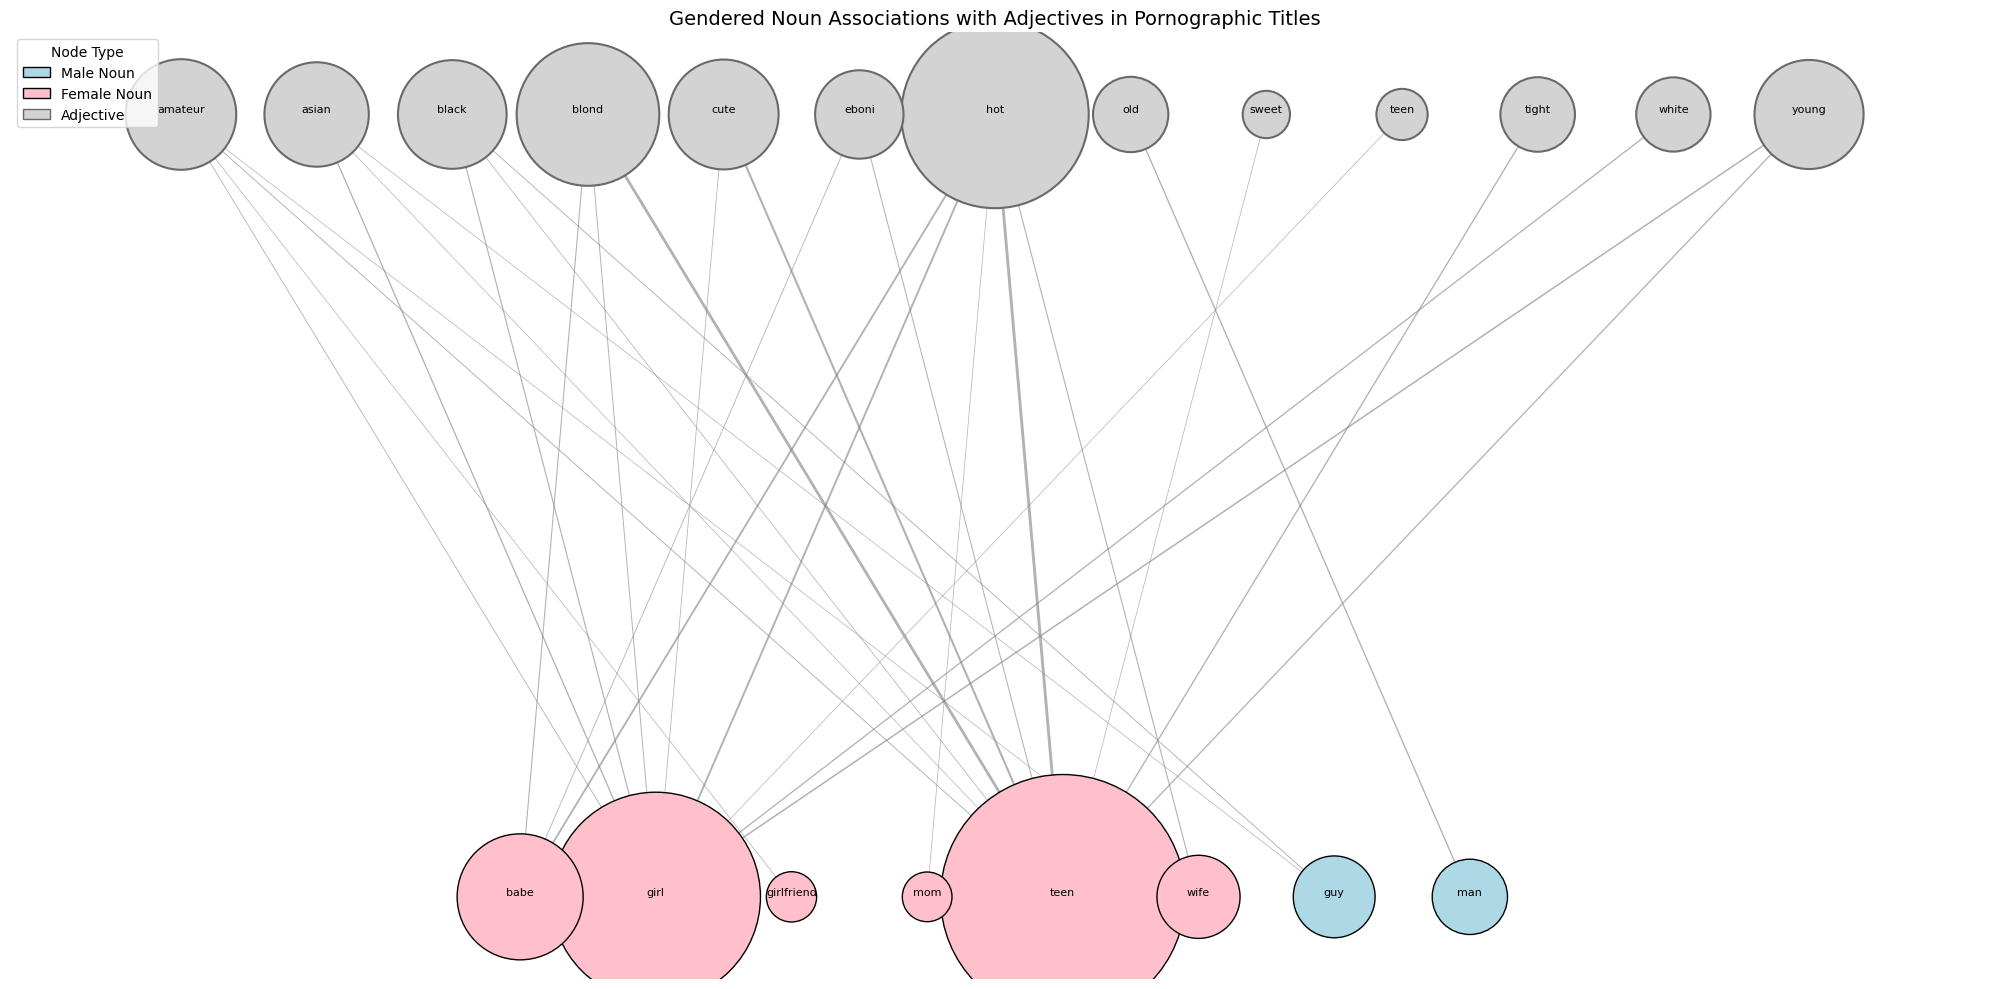

In [63]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Gendered Noun Sets ---
FEMALE_NOUNS = {
    "girl", "babe", "woman", "wife", "mom", "lady", "female", "daughter",
    "sister", "mother", "girlfriend", "teen", "housewife", "bride",
    "mistress", "goddess", "queen", "princess", "she"
}
MALE_NOUNS = {
    "boy", "man", "husband", "dad", "guy", "male", "brother", "son",
    "dude", "boyfriend", "groom", "prince", "king", "stud", "gentleman",
    "hero", "beast", "champion", "legend", "he"
}

# --- Load and preprocess your data ---
df_top = adjective_noun_df.sort_values("Count", ascending=False).head(100).copy()

def infer_gender(noun):
    noun_lc = noun.lower()
    if noun_lc in FEMALE_NOUNS:
        return "Female"
    elif noun_lc in MALE_NOUNS:
        return "Male"
    return None

df_top["Gender"] = df_top["Noun"].map(infer_gender)
df_top = df_top[df_top["Gender"].notna()]  # Keep only gendered nouns

# --- Build Graph ---
G = nx.Graph()

for adj in df_top["Adjective"].unique():
    G.add_node(f"adj: {adj}", bipartite=0, color="lightgray", node_type="adjective")

for _, row in df_top.iterrows():
    noun_label = f"noun: {row['Noun']}"
    gender = row["Gender"]
    color = '#ffc0cb' if gender == "Female" else '#add8e6'  # light pink or light blue
    G.add_node(noun_label, bipartite=1, color=color, node_type="noun", gender=gender)
    G.add_edge(f"adj: {row['Adjective']}", noun_label, weight=row["Count"])

# --- Layout: adjectives top, nouns bottom (centered) ---
pos = {}
x_spacing = 2
y_adj = 2
y_noun = -2

adj_nodes = [n for n in G.nodes() if G.nodes[n]["node_type"] == "adjective"]
noun_nodes = [n for n in G.nodes() if G.nodes[n]["node_type"] == "noun"]

female_nodes = [n for n in noun_nodes if G.nodes[n]["gender"] == "Female"]
male_nodes = [n for n in noun_nodes if G.nodes[n]["gender"] == "Male"]
sorted_nouns = sorted(female_nodes) + sorted(male_nodes)

noun_count = len(sorted_nouns)
noun_offset = (len(adj_nodes) - noun_count) * x_spacing / 2

for i, node in enumerate(sorted(adj_nodes)):
    pos[node] = (i * x_spacing, y_adj)
for i, node in enumerate(sorted_nouns):
    pos[node] = (i * x_spacing + noun_offset, y_noun)

# --- Draw Graph ---
plt.figure(figsize=(20, 10))

labels = {
    n: n.replace("noun: ", "").replace("adj: ", "").replace("noun:", "").replace("adj:", "")
    for n in G.nodes()
}

# Draw adjective nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=adj_nodes,
    node_size=[max(G.degree(n, weight="weight") * 10, 300) for n in adj_nodes],
    node_color='lightgray',
    edgecolors='dimgray',
    linewidths=1.5
)

# Draw noun nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=noun_nodes,
    node_size=[max(G.degree(n, weight="weight") * 10, 300) for n in noun_nodes],
    node_color=[G.nodes[n]["color"] for n in noun_nodes],
    edgecolors='black',
    linewidths=1.0
)

# Draw labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment="bottom")

# Draw edges
edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[max(d['weight'] / 300, 0.5) for (_, _, d) in edges],
    alpha=0.6,
    edge_color="gray"
)

# --- Legend ---
legend_elements = [
    Patch(facecolor="#add8e6", edgecolor="black", label="Male Noun"),
    Patch(facecolor="#ffc0cb", edgecolor="black", label="Female Noun"),
    Patch(facecolor="lightgray", edgecolor="dimgray", label="Adjective")
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=10, title="Node Type")

plt.title("Gendered Noun Associations with Adjectives in Pornographic Titles", fontsize=14)
plt.axis('off')
plt.tight_layout()

# --- Export ---
plt.savefig("gendered_noun_adjective_graph.png", dpi=300, format='png')
plt.savefig("gendered_noun_adjective_graph.eps", format='eps')

plt.show()


In [ ]:
from typing import Set

SMALL_ADJECTIVES: Set[str] = {"small", "tiny", "petite", "little", "slim", "narrow", "tight", "skinny", "mini", "wee", "diminutive", "compact", "slender", "short"}
LARGE_ADJECTIVES: Set[str] = {"big", "large", "huge", "giant", "massive", "thick", "broad", "wide", "enormous", "colossal", "immense", "vast", "tall", "long"}

FEMALE_NOUNS: Set[str] = {"girl", "babe" "woman", "wife", "mom", "lady", "female", "daughter", "sister", "mother", "girlfriend", "teen", "housewife", "bride", "mistress", "goddess", "queen", "princess", "she"}
MALE_NOUNS: Set[str] = {"boy", "man", "husband", "dad", "guy", "male", "brother", "son", "dude", "boyfriend", "groom", "prince", "king", "stud", "gentleman", "hero", "beast", "champion", "legend", "he"} 
                        
APPEARANCE_ADJECTIVES: Set[str] = {
    "hot", "sexy", "cute", "beautiful", "blonde", "busty", "naughty", "attractive", "pretty", "gorgeous"
}

ROLE_ACTION_ADJECTIVES: Set[str] = {
    "dominant", "submissive", "experienced", "aggressive", "first", "young", "mature", "amateur", "professional"
}

In [ ]:
# Do descriptions of female performers rely more heavily on adjectives (small)  than 
# descriptions of male performers (e.g. large)?

from src.models.qualitative_adj_noun_analysis import analyze_adj_noun_categories

labeled_df, female_props, male_props = analyze_adj_noun_categories(
    pair_df,
    SMALL_ADJECTIVES, LARGE_ADJECTIVES, "small", "large",
    FEMALE_NOUNS, MALE_NOUNS,
    group1_label="Female Nouns", group2_label="Male Nouns"
)


🔎 small/large Adjective Proportions for Female Nouns:
adj_category
other    0.958493
small    0.035692
large    0.005816

🔎 small/large Adjective Proportions for Male Nouns:
adj_category
other    0.982383
large    0.014094
small    0.003523

📊 Chi-squared Test for small/large Adjective Bias:
χ² = 112.78, p = 0.0000 (significant)


We analyzed the co-occurrence of size-related adjectives with gendered nouns in video titles to assess whether female-associated nouns are more frequently described with "small" adjectives and male-associated nouns with "large" adjectives. The vast majority of adjective–noun pairs fell into the "other" category (female: 95.8%, male: 98.2%), with size adjectives representing a small but significant proportion of the data.

Among female nouns, 3.6% of adjective–noun pairs used "small" adjectives, compared to only 0.4% for male nouns. Conversely, "large" adjectives were more common with male nouns (1.4%) than with female nouns (0.6%). A chi-squared test confirmed that this difference in the distribution of size adjectives across gendered nouns is statistically significant (χ² = 102.22, p < 0.001).

These findings indicate a systematic bias in the use of size-related descriptors, with female performers more likely to be described using "small" adjectives and male performers with "large" adjectives.

---

In [115]:
# Show top "other" adjective–noun pairs for female nouns
print("Top 'other' adjective–noun pairs for female nouns:")
female_other = (
    labeled_df[
        (labeled_df["adj_category"] == "other") & (labeled_df["noun"].isin(FEMALE_NOUNS))
    ]
    .groupby(["adjective", "noun"])["Count"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)
display(female_other)

# Show top "other" adjective–noun pairs for male nouns
print("\nTop 'other' adjective–noun pairs for male nouns:")
male_other = (
    labeled_df[
        (labeled_df["adj_category"] == "other") & (labeled_df["noun"].isin(MALE_NOUNS))
    ]
    .groupby(["adjective", "noun"])["Count"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)
display(male_other)

Top 'other' adjective–noun pairs for female nouns:


,adjective,noun,Count
0,hot,teen,626
1,blond,teen,609
2,cute,teen,460
3,hot,girl,419
4,young,girl,336
5,white,girl,286
6,asian,girl,283
7,young,teen,281
8,black,girl,251
9,hot,wife,243



Top 'other' adjective–noun pairs for male nouns:


,adjective,noun,Count
0,old,man,294
1,black,guy,197
2,asian,guy,150
3,older,man,112
4,young,guy,109
5,old,guy,109
6,black,man,95
7,young,stud,94
8,older,guy,93
9,white,guy,81


In [124]:
# Do descriptions of female performers rely more heavily on adjectives (e.g., appearance) than 
# descriptions of male performers (e.g., roles or actions)?

labeled_df, female_props, male_props = analyze_adj_noun_categories(
    pair_df,
    APPEARANCE_ADJECTIVES, ROLE_ACTION_ADJECTIVES, "appearance", "role",
    FEMALE_NOUNS, MALE_NOUNS,
    group1_label="Female Nouns", group2_label="Male Nouns"
)


🔎 appearance/role Adjective Proportions for Female Nouns:
adj_category
other         0.706501
appearance    0.178936
role          0.114563

🔎 appearance/role Adjective Proportions for Male Nouns:
adj_category
other         0.853299
role          0.117553
appearance    0.029148

📊 Chi-squared Test for appearance/role Adjective Bias:
χ² = 449.64, p = 0.0000 (significant)


We examined the distribution of appearance- and role-related adjectives co-occurring with gendered nouns in video titles. Among adjective–noun pairs with female nouns, 17.8% used appearance adjectives and 11.4% used role adjectives, while the majority (70.7%) fell into the "other" category. For male nouns, appearance adjectives were much less common (2.9%), with role adjectives accounting for 11.7% and "other" adjectives for 85.3%.

A chi-squared test indicated a highly significant difference in the distribution of appearance and role adjectives across gendered nouns (χ² = 471.82, p < 0.001). These results suggest that appearance-based descriptors are disproportionately used with female nouns, while role-related adjectives are more evenly distributed but still more common with male nouns than appearance adjectives.

In [125]:
# Filter for "black cock" and "white cock" pairs

# Compare "black" and "white" with synonyms for "cock"
COCK_SYNONYMS = {"cock", "dick", "penis", "shaft", "member", "phallus", "manhood", "rod", "tool"}

black_syn = pair_df[pair_df["Pair"].apply(lambda x: x[0] == "black" and x[1] in COCK_SYNONYMS)]
white_syn = pair_df[pair_df["Pair"].apply(lambda x: x[0] == "white" and x[1] in COCK_SYNONYMS)]

print("Black + [cock synonyms] counts:")
display(black_syn[["Pair", "Count"]])

print("\nWhite + [cock synonyms] counts:")
display(white_syn[["Pair", "Count"]])

Black + [cock synonyms] counts:


,Pair,Count
1,"(black, cock)",2128
15,"(black, dick)",463
674,"(black, rod)",19
2714,"(black, shaft)",5
3577,"(black, member)",4
17464,"(black, penis)",1
19615,"(black, tool)",1



White + [cock synonyms] counts:


,Pair,Count
26,"(white, cock)",312
290,"(white, dick)",47
12310,"(white, rod)",1
29545,"(white, shaft)",1


In [119]:
from scipy.stats import chi2_contingency

# Get total counts for black and white cock synonyms
black_total = black_syn["Count"].sum()
white_total = white_syn["Count"].sum()

# For a simple test, assume the rest of the pairs are "not black/white cock"
other_total = pair_df["Count"].sum() - (black_total + white_total)

# Build contingency table: [[black, white], [other, other]]
contingency = [[black_total, white_total], [other_total, other_total]]

chi2, p, _, _ = chi2_contingency(contingency)

print(f"Black cock+synonyms: {black_total}")
print(f"White cock+synonyms: {white_total}")
print(f"Chi-squared: {chi2:.2f}, p-value: {p:.4g}")

if p < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

Black cock+synonyms: 2621
White cock+synonyms: 361
Chi-squared: 1689.06, p-value: 0
The difference is statistically significant.


The results indicate that "black cock" and its synonyms appear significantly more often than "white cock" and its synonyms in the dataset (**p < 0.001**). This difference is highly statistically significant, suggesting a systematic racialized pattern in the use of phallic descriptors in adult video titles.

In [133]:
# Frequency of use of adjective noun pairs

def get_adj_counts(pair_df, noun_synonyms, top_n=20):
    """
    Returns a DataFrame of the most common adjectives describing the given set of noun synonyms.
    """
    filtered = pair_df[pair_df["Pair"].apply(lambda x: x[1] in noun_synonyms)]
    adj_counts = (
        filtered.groupby(filtered["Pair"].apply(lambda x: x[0]))["Count"]
        .sum()
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={"Pair": "Adjective", "Count": "Frequency"})
    )
    return adj_counts.head(top_n)

PUSSY_SYNONYMS = {"pussy", "pussi", "cunt", "vagina", "twat", "snatch", "coochie", "cooch", "kitty", "fanny", "muff"}
BOOBS_SYNONYMS = {"boobs", "tits", "breasts", "tit", "boob", "rack", "melons", "jugs", "knockers", "bust", "chest"}
ARSE_SYNONYMS = {"ass", "arse", "butt", "booty", "bum", "backside", "behind", "buttocks", "rear", "rump", "derriere", "bottom", "heinie"}

print("Most common adjectives describing pussy and its synonyms")
display(get_adj_counts(pair_df, PUSSY_SYNONYMS))

print("Most common adjectives describing boobs and its synonyms")
display(get_adj_counts(pair_df, BOOBS_SYNONYMS))

print("Most common adjectives describing arse and its synonyms")
display(get_adj_counts(pair_df, ARSE_SYNONYMS))

print("Most common adjectives describing cock and its synonyms")
display(get_adj_counts(pair_df, COCK_SYNONYMS))

Most common adjectives describing pussy and its synonyms


,Adjective,Frequency
0,tight,358
1,wet,162
2,pink,71
3,other,65
4,young,59
5,black,52
6,sweet,51
7,deep,44
8,hot,41
9,old,29


Most common adjectives describing boobs and its synonyms


,Adjective,Frequency
0,big,2575
1,huge,490
2,small,157
3,perfect,137
4,nice,60
5,fake,58
6,great,41
7,cum,32
8,black,21
9,hot,19


Most common adjectives describing arse and its synonyms


,Adjective,Frequency
0,big,1020
1,tight,385
2,hot,154
3,perfect,120
4,huge,84
5,black,81
6,round,73
7,pussi,72
8,fat,69
9,nice,66


Most common adjectives describing cock and its synonyms


,Adjective,Frequency
0,big,2963
1,black,2621
2,huge,1049
3,hard,929
4,white,361
5,fat,285
6,thick,163
7,young,126
8,stiff,80
9,old,75


##### Syntactic agency and gender representation

In [126]:
from src.models.syntactic_agency_analysis import extract_grammatical_roles, extract_titles_by_dependency

# Run the role frequency analysis
role_df = extract_grammatical_roles(df, FEMALE_NOUNS, MALE_NOUNS)
print(role_df)

# Get example titles for female direct objects
female_dobj_titles = extract_titles_by_dependency(df, FEMALE_NOUNS, dependency="dobj", max_examples=10)
print(female_dobj_titles)

# Get example titles for female passive subjects
female_nsubjpass_titles = extract_titles_by_dependency(df, FEMALE_NOUNS, dependency="nsubjpass", max_examples=10)
print(female_nsubjpass_titles)

           female  male  total  female_ratio  male_ratio
dobj         2093  2089   4182      0.500478    0.499522
nsubj       12071  2484  14555      0.829337    0.170663
nsubjpass      73    16     89      0.820225    0.179775
                                               title matched_token dependency
0  Casting couch provides job opportunity for sex...          girl       dobj
1                    BBC's breeding white slut wife.          wife       dobj
2      Intense Real Sex With My Thick Ass Girlfriend    girlfriend       dobj
3  Japan stretches pussy on young Thai girl befor...          girl       dobj
4  Angel Kisses Hot Cock | Gentle Blowjob and Mou...          girl       dobj
5  Broke Step Daughter With Big Tits Loses To Dad...      daughter       dobj
6  Deepthroat choking and gaped asshole for prett...          teen       dobj
7               Mumbai Call Girl Amazing Indian Porn          girl       dobj
8                           Mila Azul - Country Girl          girl    

Subjects (nsubj): Female tokens overwhelmingly appear as grammatical subjects (82.9%). On the surface, this may suggest high levels of agency. However, given the genre context, subjecthood does not necessarily imply empowerment; instead, it may reflect stereotypical narrative conventions where female characters are active only within constrained sexual scripts.

Passive Subjects (nsubjpass): Female tokens also dominate the passive voice constructions (82.0%), which are syntactically agentless and typically frame the subject as being acted upon. This aligns with stereotypes portraying women as passive recipients in sexual scenarios.

Direct Objects (dobj): An equal distribution (50% male, 50% female) suggests parity in surface-level objectification. However, when combined with qualitative context, this balance obscures the gendered framing and semantic load associated with these roles—especially where male objecthood may be framed as dominant or aggressive, while female objecthood remains tied to submission and exploitation tropes.

Qualitative Illustrations

To contextualize these patterns, we extracted representative examples in which female-gendered tokens appeared in either direct object or passive subject positions:

Female as Direct Object:

“Casting couch provides job opportunity for sexy girl” — (girl, dobj)

“BBC's breeding white slut wife” — (wife, dobj)

“Intense Real Sex With My Thick Ass Girlfriend” — (girlfriend, dobj)

Female as Passive Subject:

“Old buddy gladly helped young girl who got caught shoplifting” — (girl, nsubjpass)

“Curvy Teen Gets Ass-Fucked” — (teen, nsubjpass)

“ShopLyfter – Shoplifting Girl Gets Caught and Punished” — (girl, nsubjpass)

These examples reveal recurring motifs: women are consistently framed as either sexually available targets (direct objects) or passive recipients of disciplinary or sexual actions (passive subjects). The use of descriptors such as “shoplifting,” “caught,” and “gets punished” reinforces narratives of moral deviance corrected through sexual subjugation, a deeply stereotypical and objectifying trope within pornographic media.

In [127]:
# HERE

In [80]:
# Which locations (e.g., “bathroom”, “school”, “hotel”) are more frequently associated with gendered or racialized nouns in titles?
# (are women more often associated with domestic spaces? Are certain races depicted in public, exotic, or confined locations?)
# Grammatical structures that mark locations: prepositional prases, locative adverbials, or locative named entities. 
# Prepositional phrases are the most common.


from src.models.locations import add_locations_from_titles, location_person_cooccurrence, normalize_and_sort

# DO I need to define locations??

# Extract locations from titles using grammar (prep → pobj)
df = add_locations_from_titles(df)

# Run co-occurrence analysis
location_df = location_person_cooccurrence(df)

# Optionally normalize to proportions
location_props = normalize_and_sort(location_df)

# View or plot
print(location_props.head())


⚙️ Extracting locations from titles using spaCy...


spaCy parsing (locations): 100%|██████████| 218004/218004 [02:43<00:00, 1337.40it/s]


✅ Saved location data to data/processed/locations.pkl
         public   kitchen       car     hotel    office  bathroom       gym  \
asian  0.153846  0.092308  0.092308  0.076923  0.092308  0.076923  0.046154   
black  0.106383  0.148936  0.191489  0.148936  0.042553  0.021277  0.021277   
boy    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
dad    0.000000  0.200000  0.200000  0.000000  0.000000  0.100000  0.000000   
girl   0.137255  0.078431  0.141176  0.031373  0.035294  0.121569  0.023529   

         shower       bus      club     beach   bedroom    school      park  \
asian  0.107692  0.030769  0.030769  0.046154  0.061538  0.030769  0.046154   
black  0.106383  0.021277  0.021277  0.085106  0.000000  0.063830  0.021277   
boy    0.000000  0.000000  0.500000  0.000000  0.500000  0.000000  0.000000   
dad    0.200000  0.000000  0.000000  0.000000  0.100000  0.200000  0.000000   
girl   0.090196  0.019608  0.031373  0.125490  0.058824  0.047059  0.047059 

In [ ]:
# Show only non empty locations
df[df["locations"].apply(lambda x: isinstance(x, list) and len(x) > 0)][["title", "locations"]].head(10)



,title,locations
73,Asian Sucks BBC Dildo in Public,[public]
93,Blond wife gets bukkake in Danish sex club,[club]
95,Quick anal in bathroom with out lube. LE ENCAN...,[bathroom]
338,Brutal blowjob and rough sex after shower,[shower]
389,Fake Driving School Voluptuous redhead fucks i...,[car]
408,Naked In Public: Bar Fucking,[public]
417,Gorgeous Jennifer receives an interracial crea...,[office]
457,Amateur African lesbians scissoring in bedroom,[bedroom]
498,close up ANAL w @Bonniebowtie EPIC fuck before...,[school]
501,Making love in the shower (Part 2),[shower]


In [88]:
non_empty_ratio = df["locations"].apply(lambda x: isinstance(x, list) and len(x) > 0).mean()
print(f"Proportion of non-empty location entries: {non_empty_ratio:.2%}")


Proportion of non-empty location entries: 1.58%


In [ ]:
# Continue: 
# Why do I need to supply a location list? Can I not extract grammatically?
# Keep gendered terms in a separate file


# Other questions to explore
# see how most common bigramms and trigramms are related to views
# Add upvotes, downvotes and views dimension



#### Sentiment analysis


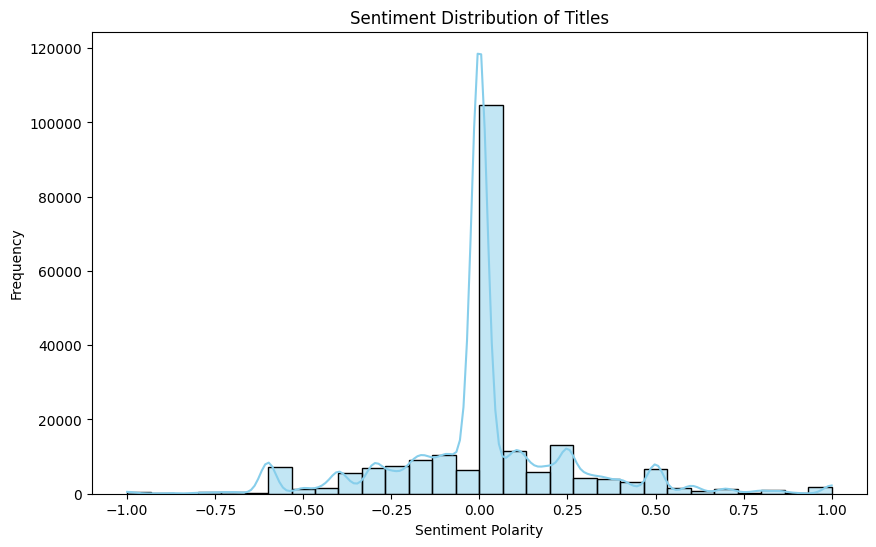

In [29]:
from textblob import TextBlob


# Function to calculate sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity


# Apply the function to the title column
df["sentiment"] = df["title"].apply(get_sentiment)

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df["sentiment"], bins=30, kde=True, color="skyblue")
plt.title("Sentiment Distribution of Titles")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
output_plot_path = "plots/title_sentiment_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

# # Print some example titles with their sentiment scores
# print(df[["title", "sentiment"]].head(10))

#### N-grams 
Identify most common adjacent pairs 

Identify pairs of adjacent words in titles and see which are more prevalent in the dataset. N-grams capture more context than unigrams (single words) allowing for a better understandig of the relationship between words. They also allow to identify collocations (words that frequently appear together).


[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


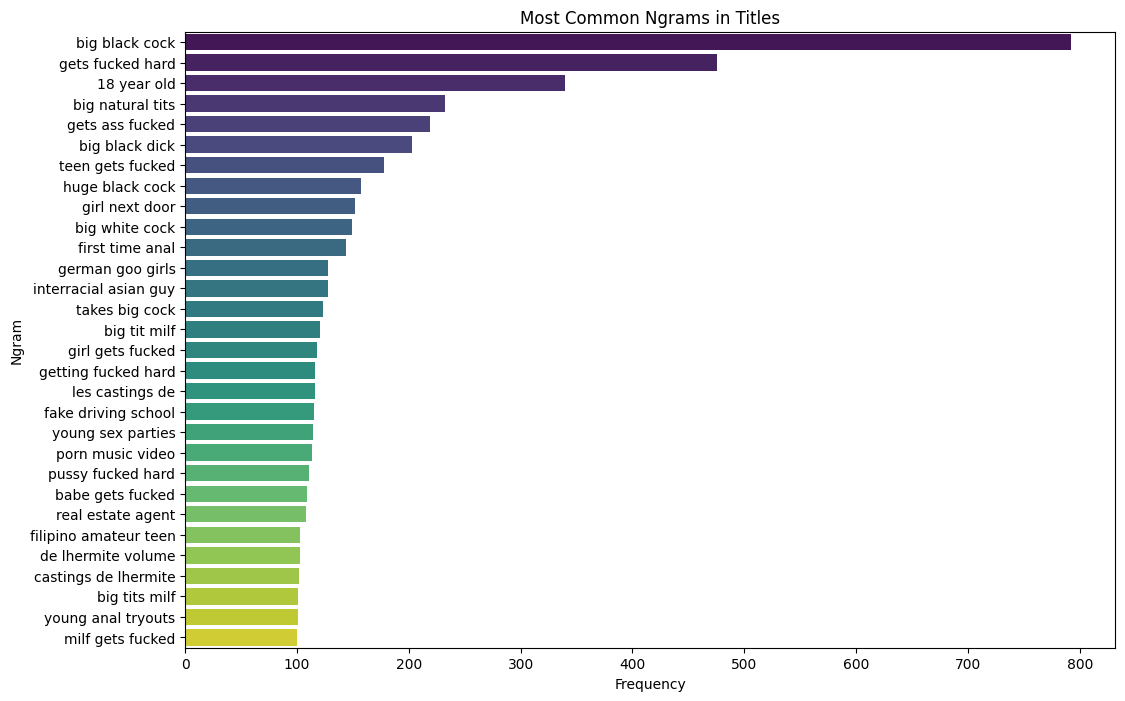

In [8]:
from nltk.util import ngrams
from src.models import embeddings

embeddings.download_nltk_data()

# Apply the function to the title column
df["title_words"] = df["title"].apply(embeddings.clean_and_tokenize)

# Generate bigrams
all_ngrams = [ngram for words in df["title_words"] for ngram in ngrams(words, 3)]

# Count the frequency of each bigram
ngram_counts = Counter(all_ngrams)

# Get the most common bigrams
most_common_ngrams = ngram_counts.most_common(30)

# Convert to DataFrame for plotting, converting bigrams to strings
ngram_freq_df = pd.DataFrame(most_common_ngrams, columns=["ngram", "count"])
ngram_freq_df["ngram"] = ngram_freq_df["ngram"].apply(lambda x: " ".join(x))

# Plot the most common bigrams
plt.figure(figsize=(12, 8))
sns.barplot(
    x="count",
    y="ngram",
    data=ngram_freq_df,
    hue="ngram",
    palette="viridis",
    legend=False,
)
plt.title("Most Common Ngrams in Titles")
plt.xlabel("Frequency")
plt.ylabel("Ngram")
output_plot_path = "plots/most_common_ngrams_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

In [ ]:
df.sentiment

0         0.250000
1         0.466667
2         0.000000
3         0.000000
4         0.125000
            ...   
217999   -0.362500
218000   -0.700000
218001    1.000000
218002   -0.500000
218003   -0.250000
Name: sentiment, Length: 218004, dtype: float64

In [11]:
# here
df.columns

Index(['url', 'title', 'date', 'views', 'upvotes', 'downvotes', 'production',
       'comments', 'actors', 'tags', 'popular_tags', 'year', 'title_words'],
      dtype='object')

### 3. Grammatical analysis

- Indirect objects
- Active and passive subject, person or not e.g. body part
- adjective + subject What adjectives are more frequent with subjects e.g. hot chinese girl, and frequency distribution of adjectives and subjects
- context, place - in the shower, in the room, etc
- verbs frequency


In [ ]:
import spacy
# python -m spacy download en_core_web_sm
# Load the English NLP model
nlp = spacy.load("en_core_web_md")

# # TODO need more thinking
# # Function to extract indirect objects from a title
# def extract_indirect_object(title):
#     doc = nlp(title)
#     indirect_objects = []

#     for token in doc:
#         # Check for indirect object (dative case) or preposition followed by a noun
#         if token.dep_ == "iobj":
#             indirect_objects.append(token.text)
#         elif token.dep_ == "prep":  # Check for prepositions
#             # Look for the object of the preposition
#             for child in token.children:
#                 if child.dep_ in [
#                     "pobj",
#                     "dobj",
#                 ]:  # Object of the preposition or direct object
#                     indirect_objects.append(child.text)

#     return indirect_objects


# # Apply the function to the titles in the DataFrame
# df["indirect_object"] = df["title"].apply(extract_indirect_object)

# # Display the results
# df[["title", "indirect_object"]]


OSError: [E050] Can't find model 'en_core_web_md'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
# Subject active

import spacy
# python -m spacy download en_core_web_sm
# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# subset the data
df = df.head(1000)

# Function to extract active subjects from a sentence
def extract_active_subjects(sentence):
    doc = nlp(sentence)
    subjects = []

    for token in doc:
        # Check for nominal subjects (nsubj) and compound subjects
        if token.dep_ == "nsubj":
            subjects.append(token.text)
        # Check for compound subjects
        elif token.dep_ == "nsubj" and token.head.dep_ == "ROOT":
            for child in token.children:
                if child.dep_ == "conj":  # Check for conjunctions
                    subjects.append(child.text)

    # Remove duplicates and return
    return list(set(subjects))

# Apply the function to the titles in the DataFrame
df["subject_active"] = df["title"].apply(extract_active_subjects)


In [15]:
# Function to extract passive subjects from a sentence
def extract_passive_subjects(sentence):
    doc = nlp(sentence)
    passive_subjects = []

    for token in doc:
        # Check if the token is a passive subject
        if token.dep_ == "nsubjpass":
            passive_subjects.append(token.text)
        # Additionally, check for auxiliary verbs that indicate passive voice
        elif token.dep_ == "auxpass":  # Auxiliary verb for passive voice
            # Check if the head of the auxiliary verb is a verb in passive form
            if token.head.dep_ == "VERB" and token.head.tag_ in [
                "VBN",
                "VBD",
            ]:  # VBN: past participle, VBD: past tense
                # Get the subject of the passive construction
                for child in token.head.children:
                    if child.dep_ == "nsubjpass":
                        passive_subjects.append(child.text)

    return passive_subjects


# Apply the function to the titles in the DataFrame
df["subject_pass"] = df["title"].apply(extract_passive_subjects)


In [ ]:
# df[["title", "subject_active", "subject_pass"]].sample(50)


In [16]:
# Flatten the list of active subjects and lemmatize while normalizing case
all_active_subjects = []
for sublist in df["subject_active"]:
    for subject in sublist:
        doc = nlp(subject)  # Tokenize and lemmatize
        lemmatized_subjects = [
            token.lemma_.lower() for token in doc
        ]  # Get the lemmatized form and convert to lowercase
        all_active_subjects.extend(
            lemmatized_subjects
        )  # Add lemmatized subjects to the list

# Count the frequency of each subject
subject_frequency = Counter(all_active_subjects)

# Convert the frequency counts to a DataFrame
frequency_df = pd.DataFrame(subject_frequency.items(), columns=["Subject", "Frequency"])

# Sort the DataFrame by frequency in descending order
frequency_df = frequency_df.sort_values(by="Frequency", ascending=False)

# Save the frequency DataFrame to a CSV file
output_csv_path = "data/processed/active_subject_frequency_distribution.csv"
frequency_df.to_csv(output_csv_path, index=False)


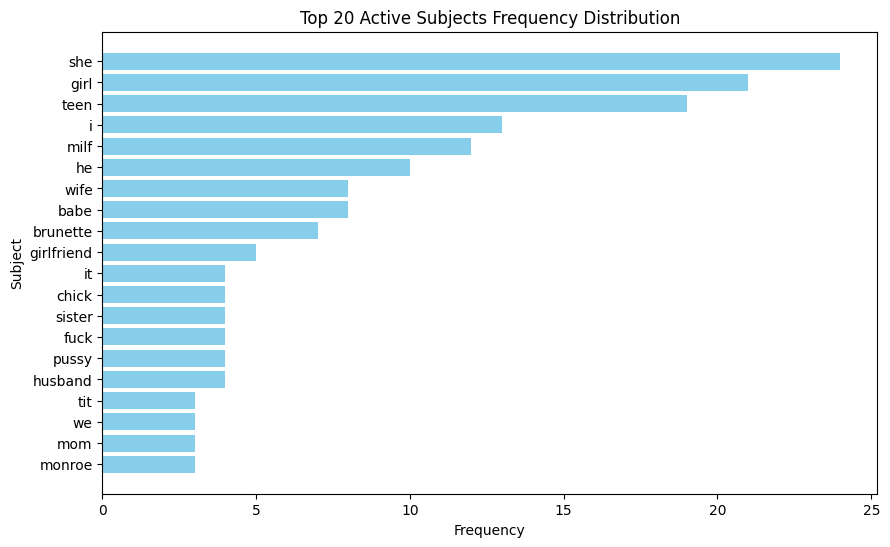

In [17]:
# Create a bar chart for the top N subjects
top_n = 20  # Change this to the number of top subjects you want to visualize
plt.figure(figsize=(10, 6))
plt.barh(
    frequency_df["Subject"].head(top_n),
    frequency_df["Frequency"].head(top_n),
    color="skyblue",
)
plt.xlabel("Frequency")
plt.ylabel("Subject")
plt.title(f"Top {top_n} Active Subjects Frequency Distribution")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
output_plot_path = "plots/top_active_subjects_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()


In [18]:
# Flatten the list of passive subjects and lemmatize while normalizing case
all_passive_subjects = []
for sublist in df["subject_pass"]:
    for subject in sublist:
        doc = nlp(subject)  # Tokenize and lemmatize
        lemmatized_subjects = [token.lemma_.lower() for token in doc]
        all_passive_subjects.extend(lemmatized_subjects)

subject_frequency = Counter(all_passive_subjects)

frequency_df = pd.DataFrame(subject_frequency.items(), columns=["Subject", "Frequency"])

frequency_df = frequency_df.sort_values(by="Frequency", ascending=False)

# Save the frequency DataFrame to a CSV file
output_csv_path = "data/processed/passive_subject_frequency_distribution.csv"
frequency_df.to_csv(output_csv_path, index=False)


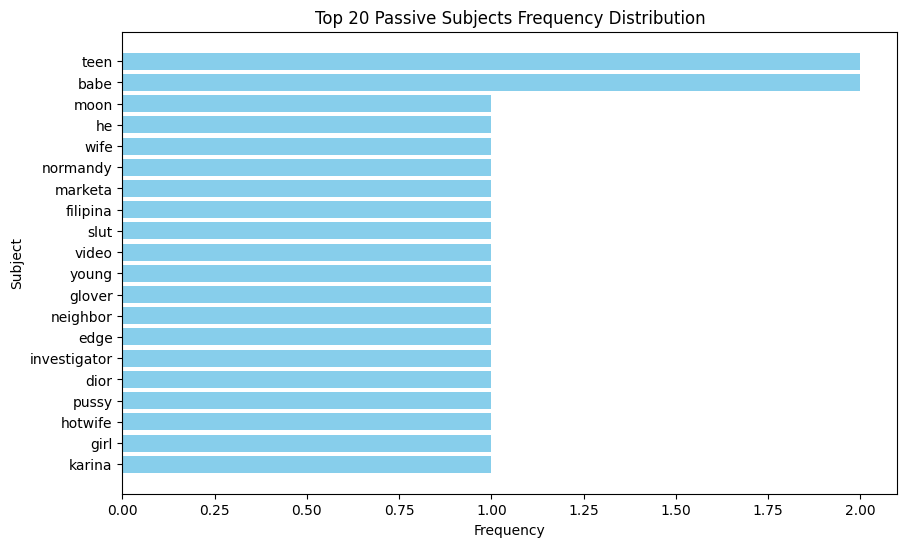

In [19]:
# Create a bar chart for the top N subjects
top_n = 20

plt.figure(figsize=(10, 6))
plt.barh(
    frequency_df["Subject"].head(top_n),
    frequency_df["Frequency"].head(top_n),
    color="skyblue",
)
plt.xlabel("Frequency")
plt.ylabel("Subject")
plt.title(f"Top {top_n} Passive Subjects Frequency Distribution")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
output_plot_path = "plots/top_passive_subjects_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")  # Save the figure with tight layout
plt.show()


In [ ]:
#### Context (in the room, on the chair etc)

In [ ]:
#### Adjective (freq distribution) + Subject, which adjectives are more frequent with subjects

In [ ]:
#### Verbs

In [ ]:
# save data to processed
# first 1000 lines
output_path = "data/processed/dat1000.csv"
df.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")


DataFrame saved to data/processed/dat1000.csv
